## Impact of Demographic Features on Offer Completion in Starbucks Rewards Program

### Project Overview

The dataset presents the customer behaviour on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free).

The goal of this project is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type and to build an ML Model to predict whether a customer would complete an offer.

### Approach

- Data Preprocessing: Handling missing values, encoding categorical variables, and feature engineering.
- Exploratory Data Analysis (EDA): Analyzing patterns, distributions, and relationships within the data to gain insights.
- Model Development: Constructed a machine learning model, considering feature importance and prediction accuracy
- Evaluation: Utilized metrics such as F1 score & classification report to assess the model's performance.

### Metrics

*F1 Score*

The F1 score is calculated as the harmonic mean of precision and recall. It is particularly useful when dealing with imbalanced classes. F1 Score provides a balance between precision and recall, where higher values indicate better model performance.

Both accuracy score and F1 score are important metrics in evaluating the effectiveness of a classification model. While accuracy measures the overall correctness of predictions, the F1 score considers the balance between precision and recall, providing a more comprehensive assessment, especially in scenarios where class distribution is uneven.

Since we are dealing with unbalanced classes we will use F1 score as our metric to compare different models.

### Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


In [482]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [483]:
# always display all columns when calling head() function.
pd.set_option('display.max_columns', None)

In [484]:
def dataframe_summary(dataframe):
    """
    Print a summarized information for a DataFrame including columns, data types, 
    sum of nulls and first row of the dataframe
    
    Arguments:
    - dataframe: DataFrame for which summarized information is required.
    
    Output:
    - Summarized information
    """
    print(f'{"Columns": >15}{"Data types":>20}{"Null count":>19}{"1st row vales":>45}') 
    for i,j,k,l in zip(dataframe.columns,dataframe.dtypes,dataframe.isnull().sum(),dataframe.iloc[0]):
        print(f'{i : >15}'f'{str(j): >15}'f'{k: >15}'f'{str(l): >55}')
    

#### Portfolio Dataset Summary Stats

In [485]:
dataframe_summary(portfolio)

        Columns          Data types         Null count                                1st row vales
         reward          int64              0                                                     10
       channels         object              0                          ['email', 'mobile', 'social']
     difficulty          int64              0                                                     10
       duration          int64              0                                                      7
     offer_type         object              0                                                   bogo
             id         object              0                       ae264e3637204a6fb9bb56bc8210ddfd


In [486]:
# unique values of offer type
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

#### Profile Dataset Summary Stats

In [487]:
dataframe_summary(profile)

        Columns          Data types         Null count                                1st row vales
         gender         object           2175                                                   None
            age          int64              0                                                    118
             id         object              0                       68be06ca386d4c31939f3a4f0e3dd783
became_member_on          int64              0                                               20170212
         income        float64           2175                                                    nan


In [488]:
# unique values of gender
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [489]:
# check for duplicates
profile.duplicated().sum()

0

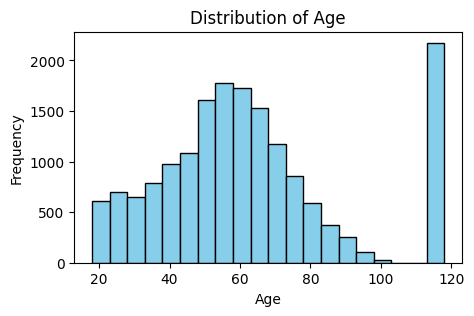

In [490]:
# Show distribution of age.
plt.figure(figsize=(5,3))
plt.hist(profile['age'], bins=20, color='skyblue', edgecolor = 'black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Looks like the age just below 120 is an outlier.

#### Transcript Dataset Summary Stats

In [491]:
dataframe_summary(transcript)

        Columns          Data types         Null count                                1st row vales
         person         object              0                       78afa995795e4d85b5d9ceeca43f5fef
          event         object              0                                         offer received
          value         object              0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
           time          int64              0                                                      0


In [492]:
# unique values of event
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

#### Data Cleaning

##### Portfolio Dataset

In [493]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [494]:
# rename id column to offer_id
portfolio = portfolio.rename(columns= {"id" : "offer_id"})

In [495]:
# convert column channels into 4 different channels and add 1 or 0 in the values
# delete original channels column later
channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
portfolio = pd.concat([portfolio, channels], axis=1, sort=False)

In [496]:
# one hot encode offer type
# delete original offer_type column later
offer_type = pd.get_dummies(portfolio['offer_type'],dtype=int)
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [497]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0


##### Profile Dataset

In [498]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [499]:
#change column name of id to customer_id
profile = profile.rename(columns={"id":"customer_id"})

In [500]:
#check duplicates
profile.duplicated().sum()

0

In [501]:
# convert the datatype of 'became_member_on' column and sort the date into proper format 
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [502]:
# get year from became_member_on column
profile['year_joined'] = profile['became_member_on'].dt.year

In [503]:
# check missing values
profile.isna().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
year_joined            0
dtype: int64

In [504]:
# age of 118 doesnot look natural
age_118_count = profile[profile['age']== 118].age.count()
age_118 = profile.loc[profile.age == 118][['gender','age','income']]
print(age_118.head())
print('Count of customers with age == 118 is {}.'.format(age_118_count))

  gender  age  income
0   None  118     NaN
2   None  118     NaN
4   None  118     NaN
6   None  118     NaN
7   None  118     NaN
Count of customers with age == 118 is 2175.


In [505]:
# age = 118 corresponds to 2175 missing values of 'gender' and 'income' columns and
# remove these rows from the profile dataframe since it is a small fraction of the data
profile = profile.dropna()


In [506]:
profile.shape

(14825, 6)

In [507]:
profile['gender'].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [508]:
# one hot encode gender column
# drop gender column later
gender_dummies = pd.get_dummies(profile["gender"], dtype=int)
profile = pd.concat([profile, gender_dummies], axis=1, sort=False)

In [509]:
profile.head(2)

,gender,age,customer_id,became_member_on,income,year_joined,F,M,O
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,0,0


##### Transcript Dataset

In [510]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [511]:
# check nulls 
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [512]:
# change person to customer_id
transcript = transcript.rename(columns={"person":"customer_id"})

In [513]:
# one hot encode event
# delete event column later
event_dummies = pd.get_dummies(transcript["event"], dtype=int)
transcript = pd.concat([transcript, event_dummies], axis=1, sort=False)

In [514]:
transcript.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0


In [515]:

# separating the 'value' column
# extract 'amount', 'offer_id, and 'reward' from the 'value' column into separate columns
# we will delete value column later
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') if 'offer_id' in x else x.get('offer id'))
transcript['rewards'] = transcript['value'].apply(lambda x: x.get('reward'))


In [516]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [517]:
transcript.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,rewards
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN


#### Combining the data

In [518]:
# combining profile and transcript 
profile_trans = pd.merge(transcript, profile, on='customer_id',how='left')

In [519]:
profile_trans.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,rewards,gender,age,became_member_on,income,year_joined,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,2017,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2018,0,1,0


In [520]:
# final dataframe consisting of profile, transcript and portfolio 
dataframe = pd.merge(profile_trans, portfolio, on='offer_id', how='left')

In [521]:
dataframe_summary(dataframe)

        Columns          Data types         Null count                                1st row vales
    customer_id         object              0                       78afa995795e4d85b5d9ceeca43f5fef
          event         object              0                                         offer received
          value         object              0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
           time          int64              0                                                      0
offer completed          int64              0                                                      0
 offer received          int64              0                                                      1
   offer viewed          int64              0                                                      0
    transaction          int64              0                                                      0
         amount        float64         148805                                               

### Data Exploration & Data Visualization

##### Age Distribution

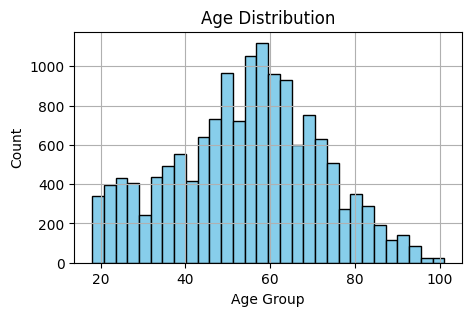

In [522]:
profile.age.hist(bins = 30,edgecolor="black",color='skyblue',figsize=(5,3))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution');

We can see that most of the customers using the starbucks app lie in the age group of 50 to 70

##### Income Distribution

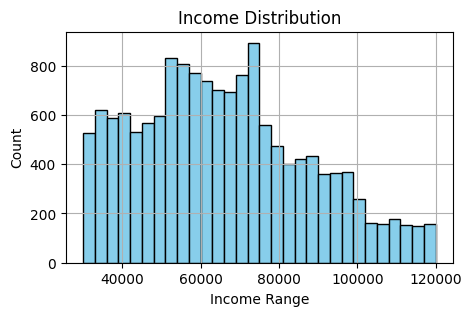

In [523]:
profile.income.hist(bins = 30,edgecolor="black",color='skyblue',figsize=(5,3));
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Distribution');

Most of the customers lie between the income range of 50k to 80k

##### Gender Distribution

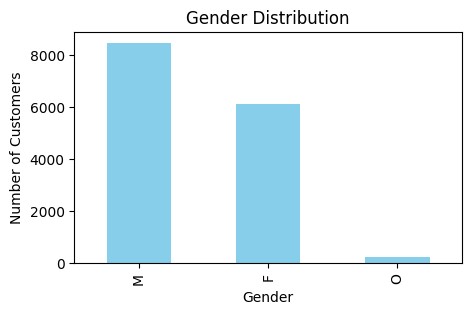

In [524]:
ax = profile.gender.value_counts()
ax.plot(kind='bar',color='skyblue',figsize=(5,3))
plt.ylabel('Number of Customers')
plt.xlabel('Gender')
plt.title('Gender Distribution');

More males are using the starbucks app, than females

##### Cumulative Spending by Gender

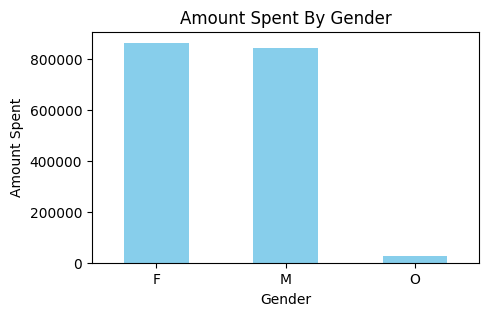

In [525]:
# Grouping the DataFrame by 'gender' and calculating the average spending for each gender
average_spending = dataframe.groupby('gender')['amount'].sum()

# Plotting a bar plot for average spending by gender
plt.figure(figsize=(5, 3))
average_spending.plot(kind='bar',color='skyblue')
plt.title('Amount Spent By Gender')
plt.xlabel('Gender')
plt.ylabel('Amount Spent')
plt.xticks(rotation=0);

Both males and females are spending equally

##### Gender Vs Membership Joining Quarter

In [526]:
dataframe['quarter'] = pd.PeriodIndex(dataframe.became_member_on, freq='Q')

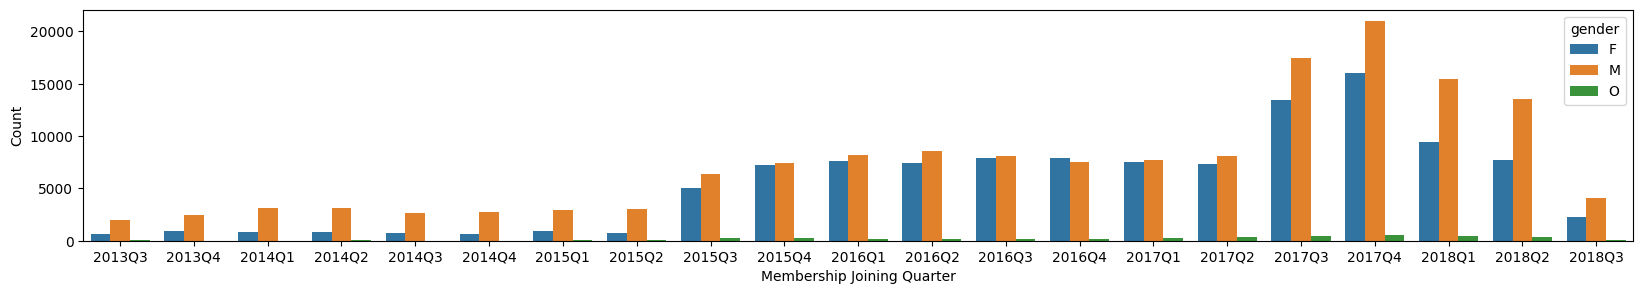

In [527]:
# groupby year month and gender to plot a graph
membership_qtr = dataframe.groupby(['quarter', 'gender']).size()
membership_qtr = membership_qtr.reset_index()
membership_qtr.columns = ['quarter', 'gender', 'count']

plt.figure(figsize=(20, 3))
sns.barplot(x='quarter', y='count', hue='gender', data=membership_qtr)
plt.xlabel('Membership Joining Quarter')
plt.ylabel('Count');

In [528]:
# max date in dataframe
dataframe.sort_values(['became_member_on'],ascending=True).iloc[-1]['became_member_on']

Timestamp('2018-07-26 00:00:00')

Both males and females have increasingly joined the starbucks app over the course of time. (comparitively more people joined in Q3 & Q4 2017).
The overall joining appears to be less in 2018, since we only have data available till july, 2018

##### Offer Type Distribution

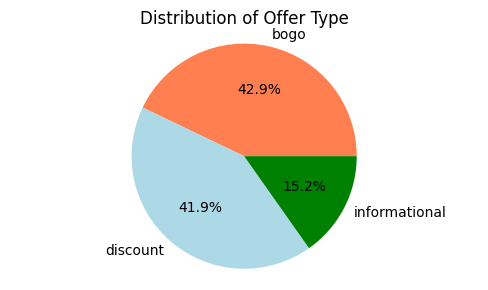

In [529]:
plt.figure(figsize=(5, 3))
plt.pie(dataframe['offer_type'].value_counts(), labels=dataframe['offer_type'].value_counts().index, autopct='%1.1f%%', colors=['coral', 'lightblue', 'green', 'lightskyblue'])
plt.title('Distribution of Offer Type')
plt.axis('equal')
plt.tight_layout();

We can see that majority of offers include bogo and discount and very few are informational

##### Offer Type Vs Offer Received, Offer Viewed and Offer Completed

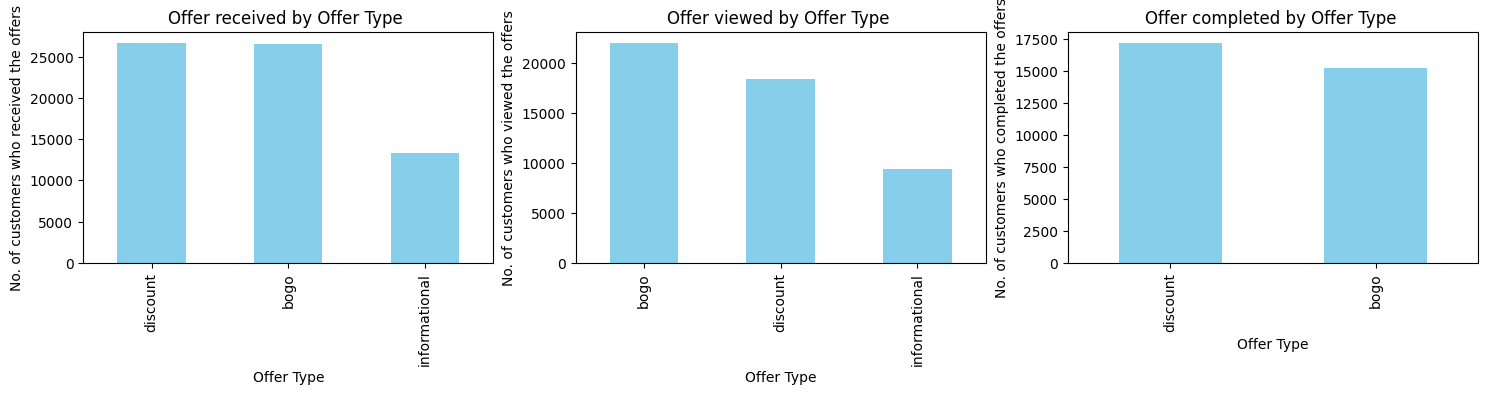

In [530]:
plt.subplot(131)
offer_received = dataframe.loc[dataframe['offer received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(18,3),color='skyblue')
plt.ylabel('No. of customers who received the offers')
plt.xlabel('Offer Type')
plt.title('Offer received by Offer Type ');

plt.subplot(132)
offer_viewed = dataframe.loc[dataframe['offer viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,3),color='skyblue')
plt.ylabel('No. of customers who viewed the offers')
plt.xlabel('Offer Type')
plt.title('Offer viewed by Offer Type ');

plt.subplot(133)
offer_completed = dataframe.loc[dataframe['offer completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(18,3),color='skyblue')
plt.ylabel('No. of customers who completed the offers')
plt.xlabel('Offer Type')
plt.title('Offer completed by Offer Type ');

We can see from the above visualizations that, discount and bogo are the most received offers and bogo is the offer that has been viewed the most. But the discount offer has been completed the most.

##### Customer Response to Offers

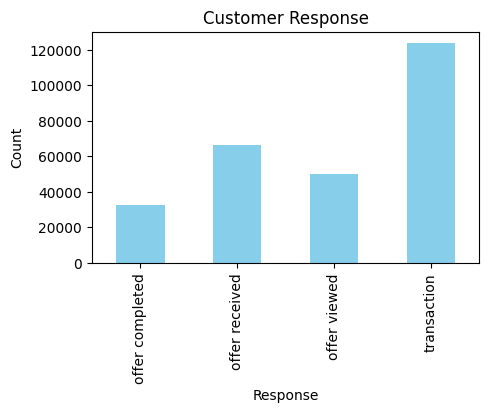

In [531]:
response = dataframe.groupby('event').size()
response.columns = ['response', 'count']

# plot a bar graph for customer response to offers
response.plot(kind = 'bar',figsize=(5,3),color='skyblue')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Customer Response');


In [532]:
offers_viewed = dataframe.loc[dataframe['event'] == "offer viewed"].shape[0]
offers_rec = dataframe.loc[dataframe['event'] == "offer received"].shape[0]
offers_completed = dataframe.loc[dataframe['event'] == "offer completed"].shape[0]


In [533]:
print("{} percent of the offers were viewed out of the total offers received".format(round(100*(offers_viewed/offers_rec),1)))

75.0 percent of the offers were viewed out of the total offers received


In [534]:
print("{} percent of the offers were completed out of the total offers received".format(round(100*(offers_completed/offers_rec),1)))

48.8 percent of the offers were completed out of the total offers received


##### Offers Completed Vs Gender, Age and Income

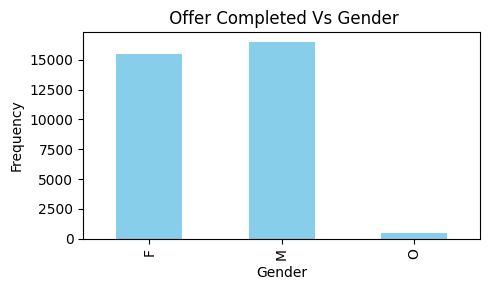

In [535]:
# Offers completed vs gender
dataframe[dataframe['offer completed']==1][['F','M','O']].sum().plot.bar(figsize=(5,3),color='skyblue') 
plt.title(" Offer Completed Vs Gender")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.tight_layout();

Males are completing little more offers than females (since they are recieving more offers as well). Although, it is almost the same. 

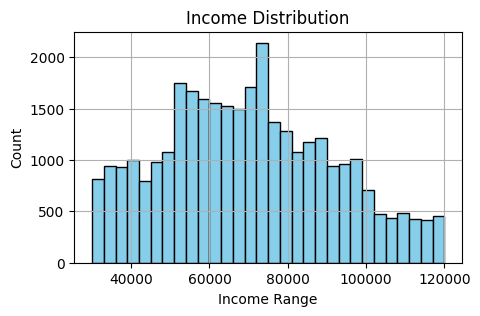

In [536]:
# Income Distribution of customers who completed the offer
dataframe_offer_comp = dataframe.loc[dataframe['offer completed'] == 1]
dataframe_offer_comp.income.hist(bins = 30,edgecolor="black",figsize=(5,3),color='skyblue')
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Distribution');

Customers having income range 50k to 80k are completing the most offers

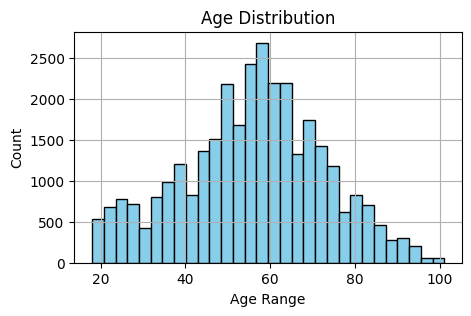

In [537]:
# Age Distribution of customers who completed the offer
dataframe_offer_comp.age.hist(bins = 30,edgecolor="black",figsize=(5,3),color='skyblue')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Age Distribution');

The customers between the age of 50-70 are the most active in completing the offers

#### Data Preparation for ML Models

In [ ]:
dataframe.columns

In [538]:
# deleting the value, event, channels and offer type columns as discussed earlier
dataframe = dataframe.drop(columns=['value','event','channels','offer_type','gender'])

In [539]:
# removing the rows where offer id is null, since we are building a model 
# to predict whether a customer will complete an offer
dataframe = dataframe.dropna(subset=['offer_id'])

In [540]:
# deleting the transaction, amount, quarter and rewards column as well
dataframe = dataframe.drop(columns=['transaction','amount','rewards','quarter'])

Also as seen in the project description above, there might be a case that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [541]:
dataframe[dataframe["offer completed"] == 1][["offer received", 'offer viewed', 'informational']].sum()

offer received    0.0
offer viewed      0.0
informational     0.0
dtype: float64

In [542]:
# dropping customer_id, offer_id, offer viewed, offer received, informational and became_memeber_on (we are keeping year_joined)
dataframe = dataframe.drop(columns=['customer_id','offer_id','became_member_on','offer viewed','offer received','informational'])

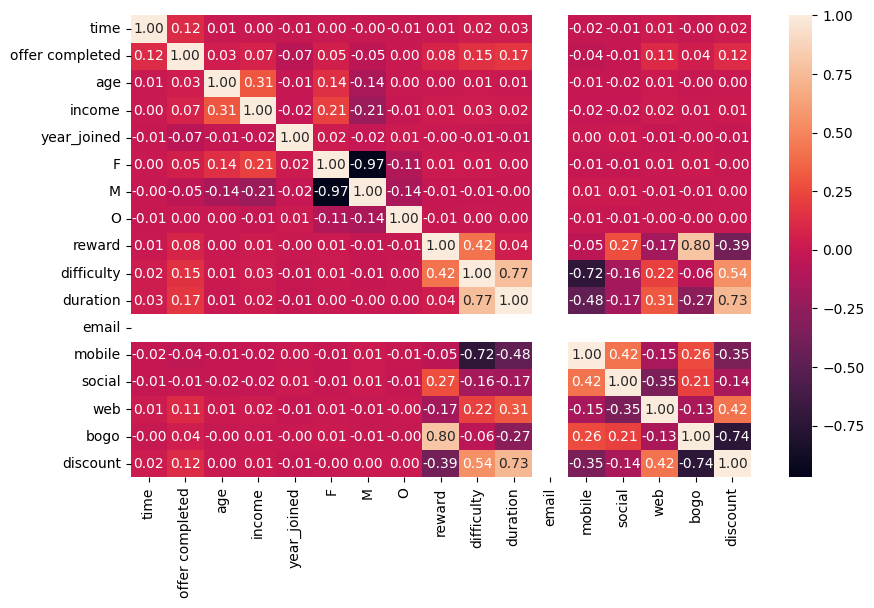

In [543]:
# plotting correlation between columns
corr = dataframe.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,fmt='.2f');

- Our target variable(offer completed) is not correlated to gender O, web and social(small correlation), hence we can remove them. 
- F & M are highly correlated, hence we can remove them as well
- email can also be removed as it is same across all rows



In [544]:
# dropping F, M, O, social, web and email
dataframe = dataframe.drop(columns=['O','M','F','social','web','email'])

In [545]:
print("We only have {} rows for which the offer has been completed out of the total {} rows".format(dataframe.loc[dataframe['offer completed']==1].shape[0],dataframe.shape[0]))

We only have 32444 rows for which the offer has been completed out of the total 148805 rows


Hence, we can clearly see that the dataset is imbalanced

In [546]:
dataframe.loc[dataframe['offer completed']==0].shape[0]

116361

In [547]:
# features and label 
features = dataframe.drop(columns=['offer completed'])
label = dataframe['offer completed']
features = features.reset_index(drop=True)
label = label.reset_index(drop=True)

In [548]:
features.head(1)

,time,age,income,year_joined,reward,difficulty,duration,mobile,bogo,discount
0,0,75,100000.0,2017,5.0,5.0,7.0,1.0,1.0,0.0


In [549]:
# scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalize_col = ['age','income','reward','difficulty','duration']
features[normalize_col] = scaler.fit_transform(features[normalize_col])

##### Training the model

In [550]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, label, stratify=label,test_size=0.2, random_state=42)

In [551]:
print("Training has {} samples".format(X_train.shape[0]))
print("Test has {} samples".format(X_test.shape[0]))

Training has 119044 samples
Test has 29761 samples


Treating the imbalanced dataset by using the SMOTE + ENN algorithm

In [552]:
from imblearn.combine import SMOTEENN
smt_en = SMOTEENN()
X_train, y_train = smt_en.fit_resample(X_train, y_train)

#### Implementing ML Models 

Since this is a binary classification problem, we have chosen to implement the following Machine learning algorithms -
- Decision Tree
- KNeighbours Classifier
- Random Forest
- Gradient Boosting Classifier

We will compare the performance metrics of the above models.

In [559]:
# Import the models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix


objects = ('DT', 'KNN', 'RF', 'GB')

In [560]:
# function to train classifier
def train_classifier(clf, X_train, y_train):    
    clf.fit(X_train, y_train)

# function to predict features 
def predict_labels(clf, features):
    return(clf.predict(features))


In [561]:
# Initialize the models
model_1 = DecisionTreeClassifier(random_state=42)
model_2 = KNeighborsClassifier(n_neighbors=1)
model_3 = RandomForestClassifier(n_estimators=40,random_state=42)
model_4 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)


In [562]:
# call function for each model & print the F1 score
clf = [model_1,model_2,model_3,model_4]
pred_val = [0,0,0,0]

for a in range(0,4):
    train_classifier(clf[a], X_train, y_train)
    y_pred = predict_labels(clf[a],X_test)
    pred_val[a] = f1_score(y_test, y_pred) 
    print("Model: {} F1 Score: {}".format(clf[a],pred_val[a]))

Model: DecisionTreeClassifier(random_state=42) F1 Score: 0.6235921036696136
Model: KNeighborsClassifier(n_neighbors=1) F1 Score: 0.6220940497910659
Model: RandomForestClassifier(n_estimators=40, random_state=42) F1 Score: 0.608958608958609
Model: GradientBoostingClassifier(random_state=42) F1 Score: 0.645993687358104


In [564]:
# generating classification report for each model
class_report = ['','','','']
for a in range(0,4):
    train_classifier(clf[a], X_train, y_train)
    y_pred = predict_labels(clf[a],X_test)
    class_report[a] = classification_report(y_test, y_pred) 
    print("{} Model: {}".format(class_report[a],clf[a]))


              precision    recall  f1-score   support

           0       0.93      0.79      0.86     23272
           1       0.51      0.79      0.62      6489

    accuracy                           0.79     29761
   macro avg       0.72      0.79      0.74     29761
weighted avg       0.84      0.79      0.80     29761
 Model: DecisionTreeClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     23272
           1       0.50      0.81      0.62      6489

    accuracy                           0.78     29761
   macro avg       0.72      0.80      0.74     29761
weighted avg       0.84      0.78      0.80     29761
 Model: KNeighborsClassifier(n_neighbors=1)
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     23272
           1       0.52      0.74      0.61      6489

    accuracy                           0.79     29761
   macro avg       0.72      0.77     

Since Gradient Boosting Classifier provides little better result compared to other techniques lets perform Grid Search on Gradient Boosting to obtain the best parameters

In [565]:
from sklearn.model_selection import GridSearchCV
# Create the Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2],'max_depth': [3, 4, 5]}

# Perform Grid Search to find the best parameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_ 
print("Best Parameters:", best_params)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# generate classification report
classification_rep = classification_report(y_test, y_pred) 
print("Classification Report:") 
print(classification_rep)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     23272
           1       0.53      0.85      0.65      6489

    accuracy                           0.80     29761
   macro avg       0.74      0.82      0.76     29761
weighted avg       0.86      0.80      0.82     29761



In [566]:
# Since Best Parameters are: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150} 
# training the model with these parameters and making predictions
model_4 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.2, max_depth=5, random_state=42)

In [567]:
clf = [model_1,model_2,model_3,model_4]
train_classifier(clf[3], X_train, y_train)
y_pred = predict_labels(clf[3],X_test)
pred_val[3] = f1_score(y_test, y_pred) 
print("Model: {} F1 Score: {}".format(clf[3],pred_val[3]))

Model: GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=150,
                           random_state=42) F1 Score: 0.6529023124115149


After performing grid search, F1 score accuracy of Gradient Boosting Classifier has increased from 
0.646 to 0.653

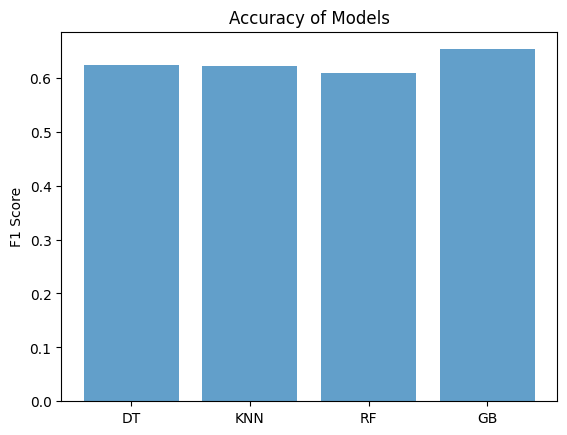

In [569]:
# ploating data for F1 Score
y_pos = np.arange(len(objects))
y_val = [ x for x in pred_val]
plt.bar(y_pos,y_val, align='center', alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('F1 Score')
plt.title('Accuracy of Models')
plt.show()

**We can see that Gradient Boosting Classifier is perfoming better than other classifiers.**

Accuracy measures how well a model correctly predicts whether an offer is successful. 
However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. 

Hence in this situation, evaluating a models' precision and recall provides better insight into its performance. F1-score metric is chosen here because it is a weighted average of the precision and recall metrics.

## Conclusion

### Reflection

In this project about the Starbucks offers data, we worked with 3 json data files including portfolio data, profile data and transcript data. 
We began by inspecting the three datasets and then cleaning them, post that we merged the datasets and then created some visualisations to further convey the information associated with our data exploration journey.

These are major goals we started with -

- Which demographic groups respond best to which offer type.
- Create Machine Learning model to predict whether a customer will complete an offer. 

The following are the outcome of our analysis - 

- Majority of the customers using the starbucks app lie in the age group of 45 to 70 and the income of most of the customers lies between 50k to 75k.
- More males are using the app, but the cumulative spending of both the males and females is the same.
- Both males and females have increasingly joined the starbucks app over the course of time. (comparitively more people joined in Q3 & Q4 2017). The overall joining appears to be less in 2018, since we only have data available till july, 2018
- 75 % of the offers were viewed out of the total offers received, and 48.8 % of the offers were completed out of the total offers received.
- Male and Female almost equally complete the offer. So offers should be sent equally among them.
- Customers having income range 50k to 80k are completing the most offers and more offers (BOGO and Discount) should be sent to them. 
- The customers between the age of 50-70 are the most active in completing the offers

During the course of this project, the most challenging task was to prepare the data for the model implementation and identify the features. It was interesting to train the (Decision Tree, KNeighbours, Gradient Boosting and Random Forest) models and make predictions. Performing grid search to find out the best parameters for the Gradient Boosting Classifier was also intriguing.

### Improvement

- As suggested, we can build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Additional machine learning models can be tested along with feature scaling
- A web app can be made showcasing various visualizations and the result of the analysis and predictions by deploying the ML model to the web app
- Build Machine Learning Pipeline to seamlessly classify new data.